In [4]:
# PATH FIX + CONST
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))

DATA_RAW = Path("../data/raw/IMBD.csv")
MODEL_NB = Path("../models/naive_bayes_genre_from_description.pkl")
print("DATA_RAW exists:", DATA_RAW.exists())


DATA_RAW exists: True


In [5]:
import pandas as pd
import numpy as np
import re

def primary_genre(s):
    if pd.isna(s): return np.nan
    return str(s).split(",")[0].strip()

df = pd.read_csv(DATA_RAW, low_memory=False)

# Giữ đúng 2 cột cần thiết cho NB
df["genre_primary"] = df["genre"].map(primary_genre)
df = df[["description","genre_primary"]].copy()

# Lọc missing/empty
df = df.dropna(subset=["description","genre_primary"])
df = df[df["description"].astype(str).str.strip().astype(bool)]

print("Rows after clean:", len(df))
print("Top genres:\n", df["genre_primary"].value_counts().head(10))


Rows after clean: 9884
Top genres:
 genre_primary
Comedy         2106
Drama          1723
Animation      1420
Documentary    1345
Action         1220
Crime           670
Adventure       315
Biography       206
Reality-TV      204
Horror          164
Name: count, dtype: int64


In [6]:
# Giữ các genre có >=5 mẫu để split stratified ổn định
vc = df["genre_primary"].value_counts()
valid = vc[vc >= 5].index
df = df[df["genre_primary"].isin(valid)].copy()

print("Classes kept:", len(valid))
print(df["genre_primary"].value_counts().sort_values(ascending=False).head(15))


Classes kept: 24
genre_primary
Comedy         2106
Drama          1723
Animation      1420
Documentary    1345
Action         1220
Crime           670
Adventure       315
Biography       206
Reality-TV      204
Horror          164
Short            95
Thriller         73
Family           65
Game-Show        61
Romance          41
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

X_text = df["description"].astype(str)
y = df["genre_primary"].astype(str)

# Thử stratify; nếu lỗi (vì còn lớp quá bé) thì fallback không stratify
try:
    Xtr, Xte, ytr, yte = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError as e:
    print("Stratify failed:", e)
    Xtr, Xte, ytr, yte = train_test_split(
        X_text, y, test_size=0.2, random_state=42, shuffle=True
    )

print("Train size:", len(Xtr), " Test size:", len(Xte))
print("Train class counts:\n", ytr.value_counts().head())


Train size: 7903  Test size: 1976
Train class counts:
 genre_primary
Comedy         1685
Drama          1378
Animation      1136
Documentary    1076
Action          976
Name: count, dtype: int64


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report

nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1,2))),
    ("clf", MultinomialNB())
])

nb_pipe.fit(Xtr, ytr)
yp = nb_pipe.predict(Xte)

acc = accuracy_score(yte, yp)
f1w = f1_score(yte, yp, average="weighted")
print(f"Accuracy = {acc:.3f} | F1-weighted = {f1w:.3f}")

# (tuỳ chọn) in báo cáo rút gọn
print("\n=== Classification report (top 10 classes in test) ===")
print(classification_report(yte, yp, zero_division=0, digits=3))


Accuracy = 0.409 | F1-weighted = 0.359

=== Classification report (top 10 classes in test) ===
              precision    recall  f1-score   support

      Action      0.662     0.193     0.298       244
   Adventure      1.000     0.095     0.174        63
   Animation      0.745     0.391     0.513       284
   Biography      0.000     0.000     0.000        41
      Comedy      0.324     0.898     0.476       421
       Crime      0.000     0.000     0.000       134
 Documentary      0.690     0.446     0.542       269
       Drama      0.359     0.426     0.389       345
      Family      0.000     0.000     0.000        13
     Fantasy      0.000     0.000     0.000         7
   Game-Show      0.000     0.000     0.000        12
      Horror      0.000     0.000     0.000        33
       Music      0.000     0.000     0.000         7
     Musical      0.000     0.000     0.000         1
     Mystery      0.000     0.000     0.000         6
        News      0.000     0.000     0.

In [9]:
import joblib, os
os.makedirs("../models", exist_ok=True)
joblib.dump(nb_pipe, MODEL_NB)
print("Saved to", MODEL_NB)


Saved to ..\models\naive_bayes_genre_from_description.pkl


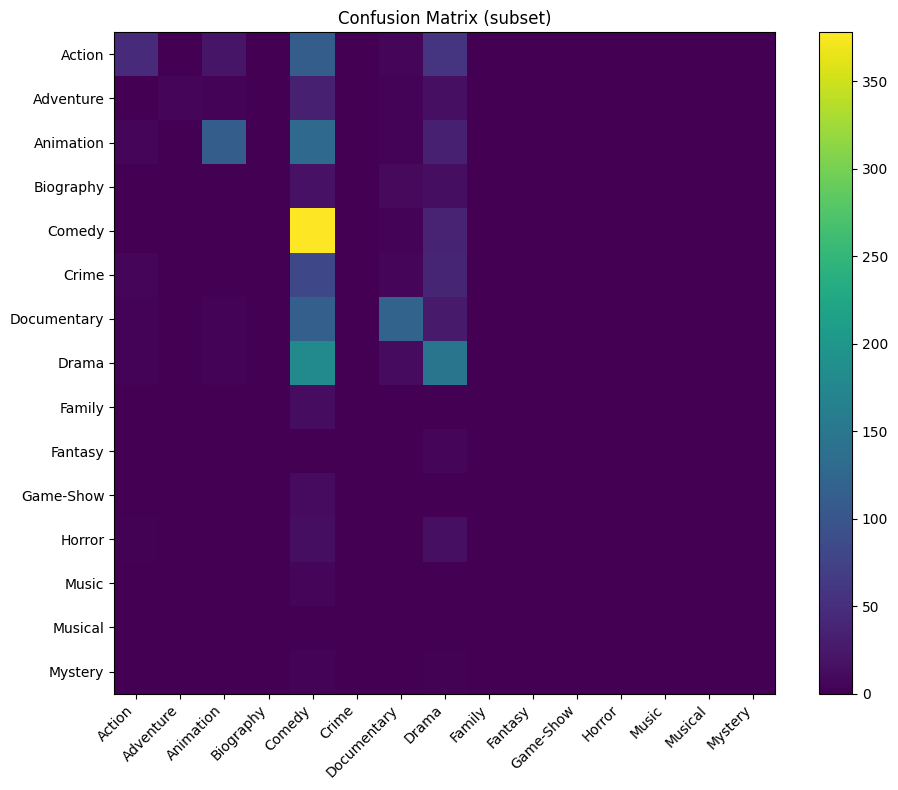

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = sorted(y.unique())[:15]  # nếu nhiều lớp, xem top 15 cho dễ nhìn
mask = yte.isin(labels)
cm = confusion_matrix(yte[mask], pd.Series(yp, index=yte.index)[mask], labels=labels)

plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (subset)")
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.tight_layout()
plt.show()
